<h1><center>DATA ANALYSIS WITH RDATAFRAME</center></h1>
<h2><center>ROOT's High Level Declarative Analysis Interface</center></h2>

RDataFrame is ROOT's way of data analysis at larger speeds compared to the older way via TTreeReader. It follows the declarative programming paradigm, where you essentially tell the program **what** you want (in a pseudo-sequential manner) rather than **how** you want, to the program. The program then does all the work for you. This simplifies thing a lot!

Previously, you might tell the program how to do stuff. Loop this, check that, then do this before doing that. Now, you mainly tell it, I want this.

RDataFrame also has the ability to benefit from multithreading, running multiple processes at the same time, vastly reducing the amount of time to carry out an analysis. Remember that reducing a 1 second job by 0.2 second might seem small, but if that job is scaled up by orders of magnitude, a 20% improvement in speed matters a lot.

The type of operations involved with RDataFrame are **transformations** where you manipulate data and **actions** where you produce the results.


Let's start off with the basics. It is recommended that you try this out in an independent macro, as Notebooks are not the right environment to carry out events that produce outputs.

In [1]:
import ROOT

# Enabling ROOT's implicit multi-threading
ROOT.EnableImplicitMT()

Welcome to JupyROOT 6.22/00


Before moving forward, we need to check the TTrees again on its content. They will be important later on.

In [2]:
f    = ROOT.TFile("./rootfiles/signal.root", "OPEN")
tree = f.Get("mumu")
tree.Print()

******************************************************************************
*Tree    :mumu      : mumu                                                   *
*Entries :    10798 : Total =          528511 bytes  File  Size =     402480 *
*        :          : Tree compression factor =   1.30                       *
******************************************************************************
*Br    0 :evtWeight_Final : evtWeight_Final/F                                *
*Entries :    10798 : Total  Size=      43881 bytes  File Size  =      31654 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.37     *
*............................................................................*
*Br    1 :passMassVCand : passMassVCand/O                                    *
*Entries :    10798 : Total  Size=      11389 bytes  File Size  =       2281 *
*Baskets :        1 : Basket Size=      32000 bytes  Compression=   4.77     *
*...................................................

Each of those branches stores values from each event, and those values can be manipulated to do selections or cuts. 

# First Step: Load the DataFrame

First off, we need to initialize a data-frame and load a tree in it

In [3]:
df = ROOT.RDataFrame("mumu", "./rootfiles/signal.root")

print(df)

A data frame built on top of the mumu dataset.


It is also possible to load multiple trees into a single data-frame using TChain.

```
df = ROOT.RDataFrame(chain)
```

# Filter(): Thinning the Dataset

By using the ```filter()``` method, we can remove events that do not fit into the filter. Unless necessary, each filter is advised to be in a container of its own and not a redefinition of the main container. After filtering, we can count the number of events in a given dataframe. The filter uses the standard writing way that you would use with TCut.

**Try:** Change around the filters and see what number of events you will get.

In [4]:
print("Original number of events/entries in the tree: ", df.Count().GetValue())

# filtering the number of events with an arbitrary filter
df_filter = df.Filter("(VCand_mass>70)&&(ZCand_mass<80)")
print("Number of events/entries in the tree after filter: ", df_filter.Count().GetValue())

Original number of events/entries in the tree:  10798
Number of events/entries in the tree after filter:  439


**Nota Belle:** Technically, due to how RDataFrame is designed to be, this is not how your are supposed to write a program with it. This is done practically for the sake of demonstration. As mentioned before, RDataFrame is declarative. A lot of the methods are **lazy actions**, i.e. you only write it first but the program only executes it when one of their results is accessed for the first time by **instant actions**.

A good practice would be to declare all transformations and actions before accessing their results (by drawing the histograms, checking the ```Count()``` value, saving the object), thus the program will run it in one go.

In the example above, the filter cuts of events that do not fit the bill. This is useful when you want to make a cutflow, because the the filtered data-frame can be filtered again, and so on.

# Define(): Custom Columns

During your analysis, you might want to use a combination of variables to manipulate the dataset, and these combinations might be have repeating members or can be impractically long if you want to use ```filter()```. Here, you can define your own columns, essentially creating a new variable.

In [5]:
# defining arbitrary new variables
df = df.Define("randVar1", "(ZCand_mass>75)&&(ZCand_mass<105)")
df = df.Define("randVar2", "(VCand_pt/100)*(ZCand_pt/100)")

# using the variable to filter events
df_filter = df.Filter("randVar1")
print("Number of events/entries in the tree with custom filter: ", df_filter.Count().GetValue())

df_filter = df.Filter("randVar2 > 100")
print("Number of events/entries in the tree with custom filter: ", df_filter.Count().GetValue())

Number of events/entries in the tree with custom filter:  10531
Number of events/entries in the tree with custom filter:  16


When you define a new variable, the variable's final value depends on the expression you give. The variable ```randVar1``` returns a Boolean flag while ```randVar2``` returns a numeric value instead.

# Range(): A Range of Events Only

When multi-threading is not enabled (the line ```EnableImplicitMT()``` was not called), the ```Range()``` method can be called. This method limits the processing of the number of events on a range of entries. This might be useful if you want to see if a certain combination of variables result in an interesting distribution, without running on all of the samples. Rather than running on all 50,000 events in a tree, a 5,000 event distribution might be enough for evaluation.

```
# running on n events
df_m = df.Range(n)

# running from event 50 until event 100
df_n = df.Range(50, 100)

# running on event 50 and onwards
df_o = df.Range(50, 0)

# picking an event for every 10
df_p = Range(0, 1000, 10)
```

# Histo1D(): Fill a Histogram

Previously, you have to run through a TTreeReader, then produce the histogram. Right now, the ```Histo1D``` method immediately outputs the histogram for a specific distribution.

In [6]:
ROOT.gStyle.SetOptStat(0)

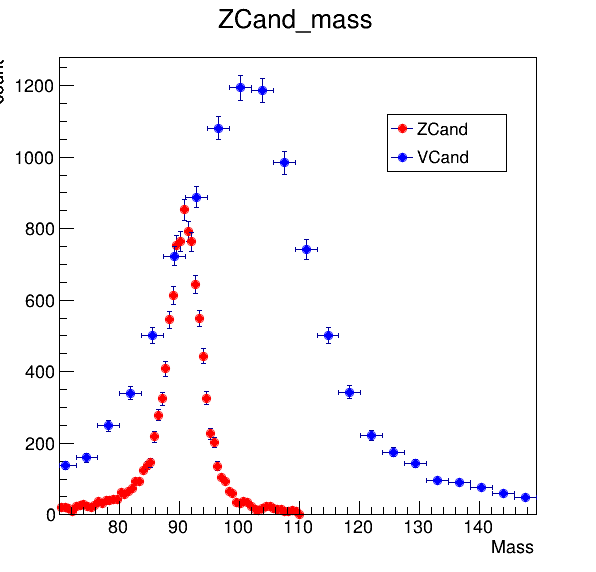

In [7]:
h1 = df.Histo1D("ZCand_mass")
h2 = df.Histo1D("VCand_mass")

for h in [h1, h2]: 
    h.GetXaxis().SetTitle("Mass")
    h.SetMaximum(h.GetMaximum()*1.5)
    h.SetMarkerStyle(20)
    
h1.SetMarkerColor(ROOT.kRed)
h2.SetMarkerColor(ROOT.kBlue)
    
lgd = ROOT.TLegend(0.65, 0.7, 0.85, 0.8)
lgd.AddEntry(h1.GetValue(), "ZCand", "lp")
lgd.AddEntry(h2.GetValue(), "VCand", "lp")
    
canv = ROOT.TCanvas("canv", "canv", 600, 600)

h1.Draw("E1")
h2.Draw("E1 SAME")
lgd.Draw()
canv.Draw()

# Snapshot(): Saving Another Tree

Sometimes, you may want to use the tree again post-analysis for other usages such as fitting or more studies. Thus, saving a portion of the tree would be a great feature.

In [14]:
# list out the variables you want to save
varList = ["ZCand_mass", "VCand_mass"]

# feed the list into a vector
branchVec = ROOT.vector('string')()
for var in varList: branchVec.push_back(var)

outTreeName = "outputTree"
outFileName = "snapshotFile.root"
df.Snapshot(outTreeName, outFileName, branchVec)

f = ROOT.TFile(outFileName, "OPEN")
f.ls()

TFile**		snapshotFile.root	snapshotFile.root
 TFile*		snapshotFile.root	snapshotFile.root
  KEY: TTree	outputTree;1	outputTree


In [15]:
tr = f.Get(outTreeName)
tr.Print()

******************************************************************************
*Tree    :outputTree: outputTree                                             *
*Entries :    10798 : Total =           88092 bytes  File  Size =      74052 *
*        :          : Tree compression factor =   1.18                       *
******************************************************************************
*Br    0 :ZCand_mass : ZCand_mass/F                                          *
*Entries :    10798 : Total  Size=      43863 bytes  File Size  =      35964 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.21     *
*............................................................................*
*Br    1 :VCand_mass : VCand_mass/F                                          *
*Entries :    10798 : Total  Size=      43863 bytes  File Size  =      37604 *
*Baskets :        2 : Basket Size=      32000 bytes  Compression=   1.15     *
*...................................................

# Extra Functionalities

## AsNumpy(): Converting into Numpy Arrays

A function is built in to accomodate people who might find it easier using the common Python libraries instead of ROOT's layered functionality. With the default constructor, it passes to you a dictionary.

In [108]:
import numpy as np

col = df_filter.AsNumpy()
print(col)

{'passZmass': ndarray([True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True], dtype=object), 'randomVar1': ndarray([True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True], dtype=object), 'randomVar2': ndarray([161.66988, 126.17994, 103.62066, 169.28513, 241.00255, 130.15208,
         165.47594, 102.5043 , 140.90009, 114.26621, 183.88396, 205.16101,
         126.18669, 297.56964, 141.77438, 132.71228], dtype=float32), 'randVar1': ndarray([True, True, True, True, True, True, True, True, True, True, True,
         True, True, True, True, True], dtype=object), 'randVar2': ndarray([161.66988, 126.17994, 103.62066, 169.28513, 241.00255, 130.15208,
         165.47594, 102.5043 , 140.90009, 114.26621, 183.88396, 205.16101,
         126.18669, 297.56964, 141.77438, 132.71228], dtype=float32), 'evtWeight_Final': ndarray([0.00778655, 0.01213918, 0.00881769, 0.00230862, 0.01164976,
         0.01074

In [50]:
print(col["VCand_mass_tag"])

[210.5636    49.574554  72.51986  236.16875   33.298225  35.84319
  58.92111  151.99416  244.2194    36.954933  98.397125  55.33683
 122.374916  37.47328   84.240616  43.547844]


This might be useful if you want to use Pandas along with other Python libraries, showing that HEP can actually be done independet of ROOT. It's just that the majority of experimental particle physicists use ROOT as their main framework.

## Listing Column Names

Printing out the data-frame or tree might be annoying to read through, as you have seen before. ```GetColumnNames()``` makes things a bit easier.

In [77]:
colNames = df.GetColumnNames()
print(colNames)

{ "passZmass", "randomVar1", "randomVar2", "randVar1", "randVar2", "evtWeight_Final", "passMassVCand", "passDeepTagWMD2p5HP", "passDeepTagWMD1p0HP", "passDeepTagWMD0p5HP", "ZVCand_mass", "ZCand_pt", "VCand_pt", "VCand_mass_tag", "VCand_deepTagMD_WvsQCD", "ZCand_eta", "ZCand_phi", "ZCand_mass", "VCand_phi", "VCand_mass" }


## Graphs and 2-D Histograms

You can also print out graphs, and 2-D histograms alongside 1-D histograms.

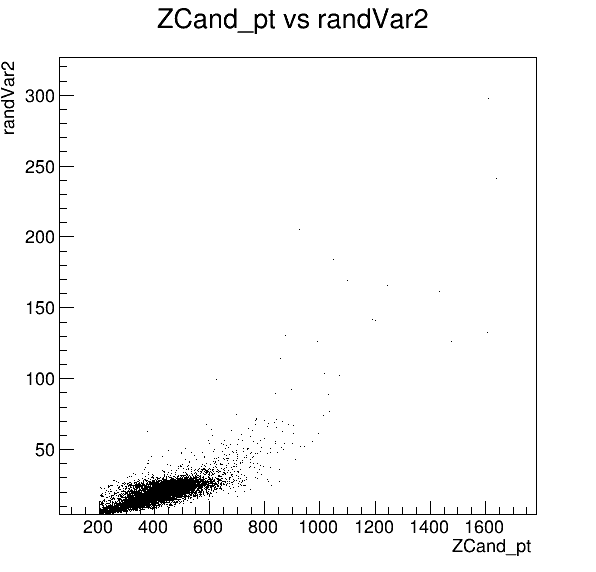

In [89]:
gr = df.Graph("ZCand_pt", "randVar2")
canv.Clear()
gr.Draw("ap")
canv.Draw()

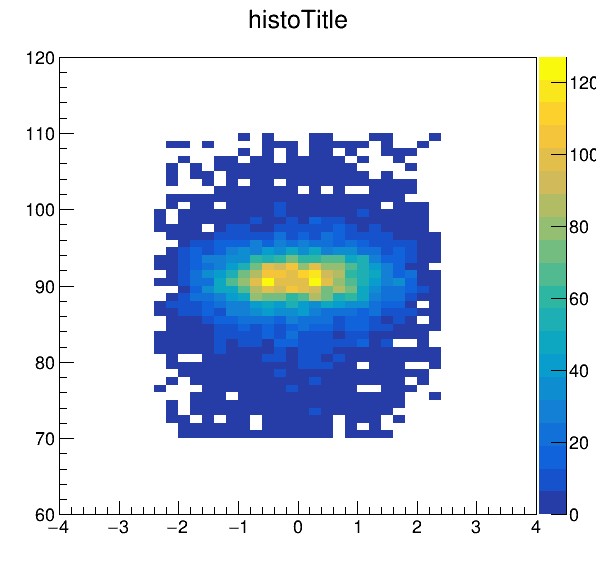

In [97]:
# declare the histogram parameters into a tuple
histo2DDec = ("histoName", "histoTitle", 40, -4, 4, 60, 60, 120)

# feed the tuple inside, and the 2 variables you want to plot
h3 = df.Histo2D(histo2DDec, "ZCand_eta", "ZCand_mass")
canv.Clear()
h3.Draw("colz")
canv.Draw()